# Reproducing Results from the Paper
This notebook will show the results from the paper after running all the experiments. The required files should be saved in the corresponding directories.

## Table of Contents <a class="anchor" id="bullet0"></a>

### Simulated Dataset

* [Performance on simulated datasets](#bullet1)
* [WinIT performance on Delayed Spike for different window sizes](#bullet2)
* [Saliency map](#bullet3)

### MIMIC Experiments

* [Load the results for MIMIC-III experiments](#bullet4)
* [Performance on MIMIC using END masking](#bullet5)
* [AUC Drop performance on MIMIC-III mortality using different metrics in WinIT for STD masking](#bullet6)
* [Counts of masked observations for IG, FIT, Dynamask and WinIT at each time step in the MIMIC-III K=50 performance drop experiment](#bullet7)
* [Performance on MIMIC for different window sizes](#bullet8)
* [Saliency map](#bullet9)
* [Precision-Recall Curve for Dynamask](#bullet10)
* [AUC Drop, Mean Prediction Changes and number of masked observations for STD-BAL, STD and END masking method for different explainability methods on K=50](#bullet11)
  * [1-Layer GRU](#bullet12)
  * [ConvNet](#bullet13)
  * [LSTM](#bullet14)
  * [3-Layer GRU](#bullet15)

Import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import pickle as pkl

In [2]:
pd.options.display.float_format = '{:.3f}'.format

A convenient function to simplify the explainer string, especially for dynamask.

In [3]:
def simplify_explainer_str(x):
    explainer_name = x.split("_")[0]
    if explainer_name not in ["winit"]:
        return explainer_name
    return x

### Performance on the simulated datasets. <a class="anchor" id="bullet1"></a> $\quad$ [TOP](#bullet0) 


In [4]:
show_std = True

sims = ["spike", "spike_delay_2", "state"]
explainers = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", "dynamask", "winit_window_10_pd"]
to_show = ["mean", "std"] if show_std else ["mean"]
dic = {}
for sim in sims:
    df = pd.read_csv(f"../output/gru1layer/simulated_{sim}/results.csv")
    df["explainer"] = df["explainer"].apply(simplify_explainer_str)
    df = df[df["explainer"].apply(lambda x: x in explainers)]
    dh = (df
          .drop(["cv", "Auroc", "Pos ratio", "Mean rank"], axis=1)
          .groupby(by=["dataset", "explainer"])
          .agg(to_show)
          .reset_index(0)
          .drop(["dataset", "Avpr"], axis=1, level=0)
          .loc[explainers]
         )
    dic[sim] = dh

pd.concat(dic, axis=1)

spike                             spike_delay_2        \
                   Auprc       Mean rank (min)               Auprc         
                    mean   std            mean   std          mean   std   
explainer                                                                  
deeplift           0.887 0.107           1.207 0.189         0.883 0.143   
gradientshap       0.426 0.044           2.739 0.242         0.465 0.112   
ig                 0.378 0.065           3.000 0.210         0.421 0.102   
fo                 0.187 0.332           5.221 2.794         0.005 0.001   
afo                0.944 0.010           1.011 0.010         0.005 0.001   
fit                0.803 0.100           1.019 0.032         0.002 0.001   
dynamask           0.503 0.000           1.000 0.000         0.502 0.002   
winit_window_10_pd 1.000 0.000           1.000 0.000         0.996 0.009   

                                          state                               
                   Mean rank (min)        Auprc       Mean rank (min)         
                              mean    std  mean   std            mean    std  
explainer                                                                     
deeplift                     1.312  0.367 0.022 0.000         284.543  1.237  
gradientshap                 2.674  0.445 0.021 0.000         286.512  1.462  
ig                           3.081  0.505 0.022 0.000         285.119  1.188  
fo                          15.616  4.818 0.027 0.000         198.436  1.964  
afo                         26.051 13.465 0.027 0.000         201.636  1.707  
fit                        167.615 34.063 0.230 0.013         116.082 12.442  
dynamask                     1.125  0.171 0.278 0.003          79.909  0.720  
winit_window_10_pd           1.004  0.008 0.260 0.010          84.692  2.058

### WinIT performance on Delayed Spike for different window sizes  <a class="anchor" id="bullet2"></a>$\quad$ [TOP](#bullet0) 

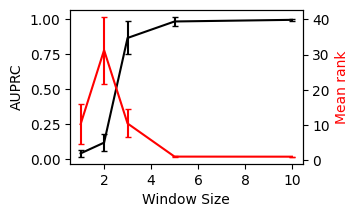

In [5]:
show_std = True
windows = [1,2,3,5,10]

dg = pd.read_csv(f"../output/gru1layer/simulated_spike_delay_2/results.csv")
explainers = [f"winit_window_{window}_pd" for window in windows]
to_show = ["mean", "std"] if show_std else ["mean"]
dg = (dg
      .drop(["cv", "Auroc", "Pos ratio", "Mean rank", "dataset", "Avpr"], axis=1)
      .groupby(by=["explainer"])
      .agg(to_show)
      .loc[explainers]
     )

plt.close()
fig, ax = plt.subplots(figsize=(3, 2))
ax.errorbar(windows, dg["Auprc"]["mean"], yerr=dg["Auprc"]["std"], capsize=2, color="black")
ax.set_ylabel("AUPRC")
ax.set_xlabel("Window Size")

ax2 = ax.twinx()
ax2.set_ylabel('Mean rank', color="red")
ax2.errorbar(windows, dg["Mean rank (min)"]["mean"], yerr=dg["Mean rank (min)"]["std"], capsize=2, color="red")
plt.show()

### Saliency maps <a class="anchor" id="bullet3"></a>$\quad$ [TOP](#bullet0) 

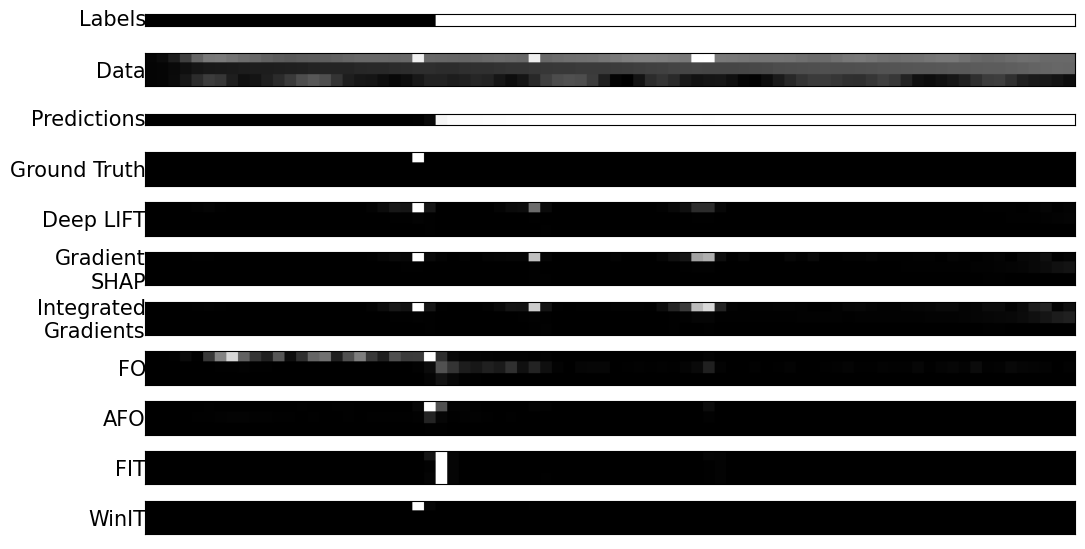

In [6]:
j = 9
sim = "spike_delay_2"
cv = 0

extras = ['labels', 'data', f'preds_cv_{cv}', 'ground_truth_attributions']
extra_names = ['Labels', "Data", "Predictions", "Ground Truth"]
explainers = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", "winit_window_10_pd"]
explainer_names = ["Deep LIFT", "Gradient\nSHAP", "Integrated\nGradients", "FO", "AFO", "FIT", "WinIT"]

plt.close()
fig, ax = plt.subplots(len(explainers)+len(extras), 1, figsize=(12, 7))

for i, (extra, extra_name) in enumerate(zip(extras, extra_names)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{extra}_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
        ax[i].text(0, 3 if extra in ['labels', f'preds_cv_{cv}'] else 12, extra_name, 
                   ha='right', fontsize=15, va="center")

for i, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names)):
    i = i + len(extras)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    file_name = f"../plots/gru1layer/simulated_{sim}/{explainer}_mean_cv_{cv}_attributions_{j}.png"
    with Image.open(file_name) as im:
        ax[i].imshow(im)
    ax[i].text(0, 12, explainer_name, ha="right", fontsize=15, va="center")

plt.show()

### Load the results for MIMIC-III experiments. <a class="anchor" id="bullet4"></a>$\quad$ [TOP](#bullet0) 

In [7]:
df = pd.read_csv("../output/gru1layer/mimic/results.csv")
df["explainer"] = df["explainer"].apply(simplify_explainer_str)
df = df.rename(columns={"level_0": "drop"})

### Performance on MIMIC using END masking <a class="anchor" id="bullet5"></a>$\quad$ [TOP](#bullet0) 

In [8]:
show_std = True

explainers = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", "dynamask", "winit_window_10_pd"]
to_show = ["mean", "std"] if show_std else ["mean"]
dh = (df.drop(["cv", "avg_masked_count"], axis=1)
      .groupby(by=["drop", "explainer"])
      .agg(to_show)
      .reset_index(0)
      .loc[explainers]
     )

dh_1 = dh[dh["drop"] == "top50_end_mean"].drop("drop", axis=1, level=0)
dh_2 = dh[dh["drop"] == "globaltop5_end_mean"].drop("drop", axis=1, level=0)
pd.concat({"Top 5%": dh_2, "Top 50": dh_1}, axis=1)

Top 5%                             Top 50        \
                   auc_drop       avg_pred_diff       auc_drop         
                       mean   std          mean   std     mean   std   
explainer                                                              
deeplift              0.025 0.002         0.031 0.002    0.021 0.003   
gradientshap          0.022 0.004         0.030 0.002    0.021 0.004   
ig                    0.021 0.003         0.030 0.002    0.020 0.004   
fo                    0.047 0.004         0.045 0.003    0.067 0.008   
afo                   0.049 0.009         0.050 0.002    0.066 0.007   
fit                   0.066 0.007         0.056 0.003    0.073 0.007   
dynamask              0.068 0.004         0.068 0.004    0.082 0.007   
winit_window_10_pd    0.098 0.008         0.080 0.004    0.099 0.008   

                                        
                   avg_pred_diff        
                            mean   std  
explainer                               
deeplift                   0.029 0.002  
gradientshap               0.027 0.002  
ig                         0.027 0.002  
fo                         0.057 0.004  
afo                        0.060 0.003  
fit                        0.070 0.003  
dynamask                   0.076 0.004  
winit_window_10_pd         0.079 0.004

### AUC Drop performance on MIMIC-III mortality using different metrics in WinIT for STD masking. <a class="anchor" id="bullet6"></a>$\quad$ [TOP](#bullet0) 

In [9]:
show_std = True

to_show = ["mean", "std"] if show_std else ["mean"]
dh = (df[df["explainer"].apply(lambda x: x.startswith("winit_window_10"))]
      .drop(["cv", "avg_masked_count", "avg_pred_diff"], axis=1)
      .groupby(by=["drop", "explainer"])
      .agg(to_show)
      .reset_index(0)
     )
dh_1 = dh[dh["drop"] == "top50_std_mean"].drop("drop", axis=1, level=0)
dh_2 = dh[dh["drop"] == "globaltop5_std_mean"].drop("drop", axis=1, level=0)
dh = pd.concat({"Top 5%": dh_2, "Top 50": dh_1}, axis=1)
dh

Top 5%         Top 50      
                   auc_drop       auc_drop      
                       mean   std     mean   std
explainer                                       
winit_window_10_js    0.075 0.007    0.072 0.007
winit_window_10_kl    0.076 0.006    0.072 0.007
winit_window_10_pd    0.078 0.008    0.076 0.006

### Counts of masked observations for IG, FIT, Dynamask and WinIT at each time step in the MIMIC-III _K_=50 performance drop experiment. <a class="anchor" id="bullet7"></a>$\quad$ [TOP](#bullet0) 
Note that the bar charts are overlapping, instead of stacking.

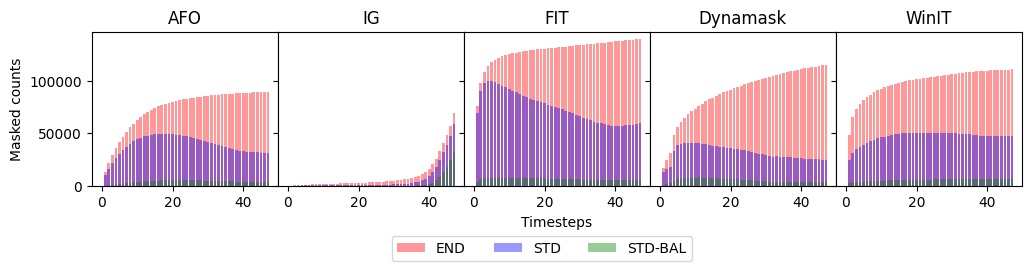

In [10]:
drops = ["top50_end_mean", "top50_std_mean", "bal50_std_mean"]
drop_names = ["END", "STD", "STD-BAL"]
explainers = ["afo", "ig", "fit", "dynamask_fadema_deletion_timereg_0_sizereg_10000_area_0.05_epoch_200",
              "winit_window_10_pd"]
explainer_names = ["AFO", "IG", "FIT", "Dynamask", "WinIT"]
colors = ["red", "blue", "green"]

dic = {}
for drop, explainer in itertools.product(drops, explainers):
    li = [
        np.load(f"../plots/gru1layer/mimic/array/{explainer}_{drop}_all_mask_cv_{cv}.npy")
        for cv in range(5)
    ]
    dic[f"{drop}_{explainer}"] = np.mean(np.stack(li), axis=0)

plt.close()
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, len(explainers), hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for j, (explainer, explainer_name) in enumerate(zip(explainers, explainer_names)):
    for i, (drop, drop_name, color) in enumerate(zip(drops, drop_names, colors)):
        arr = dic[f"{drop}_{explainer}"]
        axs[j].bar(np.arange(len(arr)), arr, alpha=0.4, color=colors[i], label=drop_name)
    axs[j].set_title(explainer_name)
    
axs[0].set_ylabel("Masked counts")
axs[2].set_xlabel("Timesteps")
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.3))
plt.show()

### Performance on MIMIC for different window sizes <a class="anchor" id="bullet8"></a>$\quad$ [TOP](#bullet0) 

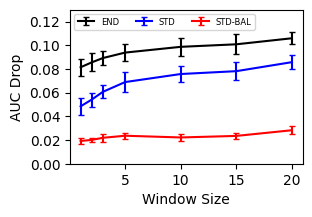

In [11]:
drops = ["top50_end_mean", "top50_std_mean", "bal50_std_mean"]
drop_names = ["END", "STD", "STD-BAL"]
colors = ["black", "blue", "red"]
windows = [1,2,3,5,10,15,20]
explainers = [f"winit_window_{w}_pd" for w in windows]
dh = (df
      .drop(["cv", "avg_masked_count", "avg_pred_diff"], axis=1)
      .groupby(["drop", "explainer"])
      .agg(["mean", "std"])
     )

plt.close()
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_ylabel("AUC Drop")
ax.set_xlabel("Window Size")

for drop, drop_name, color in zip(drops, drop_names, colors):
    dj = dh.loc[drop].loc[explainers]["auc_drop"]
    ax.errorbar(windows, dj["mean"], yerr=dj["std"], capsize=2, color=color, label=drop_name)
ax.legend(loc="upper left", ncol=3, fontsize=6)
ax.set_ylim(0, 0.13)
ax.set_yticks(np.arange(0, 0.13, 0.02))
plt.show()

### Saliency map <a class="anchor" id="bullet9"></a>$\quad$ [TOP](#bullet0) 

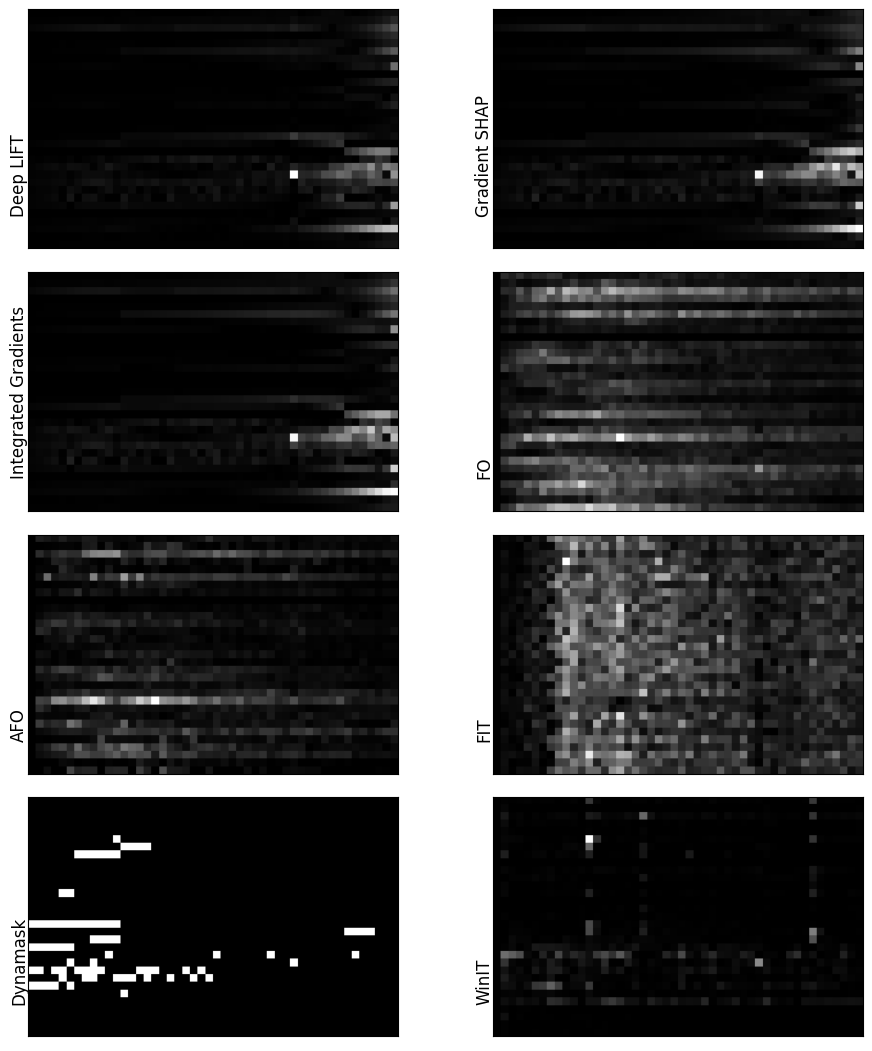

In [12]:
j = 1
cv = 0

explainers_mimic = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", 
                    "dynamask_fadema_deletion_timereg_0_sizereg_10000_area_0.05_epoch_200", 
                    "winit_window_10_pd"]
explainer_names = ["Deep LIFT", "Gradient SHAP", "Integrated Gradients", "FO", "AFO", 
                   "FIT", "Dynamask", "WinIT"]

plt.close()
ncols = 2
nrows = -(-len(explainers_mimic) // ncols)
aspect = ncols / nrows * 1.8
width = 12
height = width / aspect

fig = plt.figure(figsize=(width, height))
gs = fig.add_gridspec(nrows, ncols, hspace=0.1, wspace=0)
ax = gs.subplots().reshape(-1)
for i, (explainer, explainer_name) in enumerate(zip(explainers_mimic, explainer_names)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    with Image.open(f"../plots/gru1layer/mimic/{explainer}_mean_cv_{cv}_attributions_{j}.png") as im:
        ax[i].imshow(im)
    ax[i].text(0, 350, explainer_name, ha="right", fontsize=12, rotation=90)

plt.show()

### Precision-Recall Curve for Dynamask <a class="anchor" id="bullet10"></a>$\quad$ [TOP](#bullet0) 

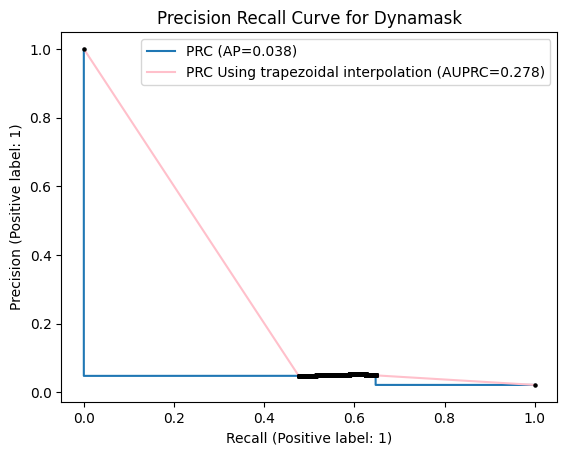

In [13]:
cv = 0
files = [f for f in os.listdir("../output/gru1layer/simulated_state/") if f.startswith("dynamask") and f.endswith(f"{cv}.pkl")]
with open("../output/gru1layer/simulated_state/" + files[0], "rb") as f:
    imp = pkl.load(f)
    
with open('../data/simulated_state_data/state_dataset_importance_test.pkl', 'rb') as f:
    gt = pkl.load(f)

p, r, t = precision_recall_curve(gt.reshape(-1), imp.reshape(-1))
    
plt.close()
display = PrecisionRecallDisplay.from_predictions(
    gt.reshape(-1), imp.reshape(-1)
)
_ = display.ax_.set_title("Precision Recall Curve for Dynamask")
display.ax_.plot(r, p, color="pink", label="PRC Using trapezoidal interpolation (AUPRC=0.278)")
h, l = display.ax_.get_legend_handles_labels()
display.ax_.scatter(r, p, color="black", s=5, zorder=100)
l[0] = "PRC (AP=0.038)"
display.ax_.legend(h, l)
plt.show()

### AUC Drop, Mean Prediction Changes and number of masked observations for STD-BAL, STD and END masking method for different explainability methods on _K_=50 <a class="anchor" id="bullet11"></a>$\quad$ [TOP](#bullet0) 

In [14]:
def show_masking_barcharts(model_architecture):
    df = pd.read_csv(f"../output/{model_architecture}/mimic/results.csv")
    df["explainer"] = df["explainer"].apply(simplify_explainer_str)
    df = df.rename(columns={"level_0": "drop"})

    explainers = ["deeplift", "gradientshap", "ig", "fo", "afo", "fit", "dynamask", "winit_window_10_pd"]
    explainer_names = ["Deep LIFT", "GradSHAP", "IG", "FO", "AFO", "FIT", "Dynamask", "WinIT"]
    graphs = ["auc_drop", "avg_pred_diff", "avg_masked_count"]
    graph_names = ["AUC Drop", "Pred. Change", "Masked Count"]

    drops = ["STD-BAL", "STD", "END"]
    num_explainers = len(explainers)
    colors = ["pink", "pink", "pink", "greenyellow", "greenyellow", "blue", "orange", "mediumpurple"]
    hatches = [None, "///", "++", None, "///", None, None, None]
    ind = np.arange(3)
    width = 0.8
    bar_width = width / num_explainers

    dh = df.drop("cv", axis=1).groupby(by=["explainer", "drop"]).agg("mean").reset_index()
    dh = dh[dh["drop"].apply(lambda x : not x.startswith("global"))]
    dh["drop"] = dh["drop"].apply(lambda x: "STD-BAL" if x.startswith("bal") else x.split("_")[1].upper())

    plt.close()
    fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
    for j, (graph, graph_name) in enumerate(zip(graphs, graph_names)):
        for i, (explainer, explainer_name, color, hatch) in enumerate(
            zip(explainers, explainer_names, colors, hatches)):
            data = dh[dh["explainer"] == explainer].set_index("drop").loc[drops, graph]
            data = np.maximum(data, 0)
            ax[j].barh(ind + i * bar_width, data, bar_width, color=color, 
                       label=explainer_name, hatch=hatch, edgecolor="black")
        ax[j].set_yticks(ind + bar_width * (num_explainers - 1) / 2)
        ax[j].set_yticklabels(drops, rotation=90, va="center")
        ax[j].set_title(graph_name)
        handles, labels = ax[j].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncols=4)
    plt.show()

### Base model = 1-Layer GRU <a class="anchor" id="bullet12"></a>$\quad$ [TOP](#bullet0) 

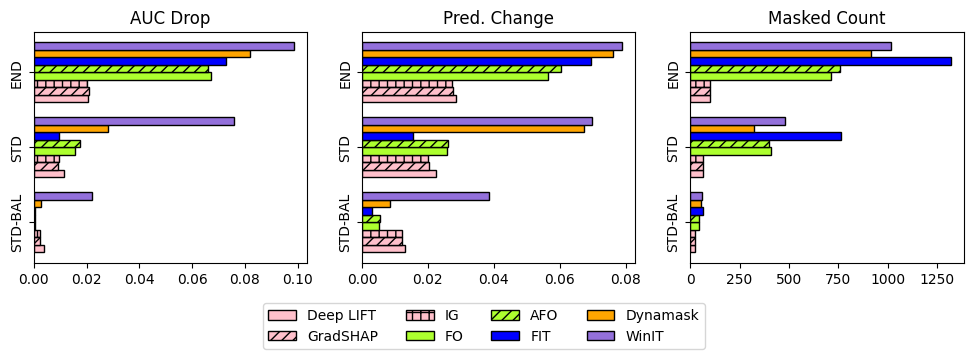

In [15]:
show_masking_barcharts("gru1layer")

### Base model = ConvNet <a class="anchor" id="bullet13"></a>$\quad$ [TOP](#bullet0) 

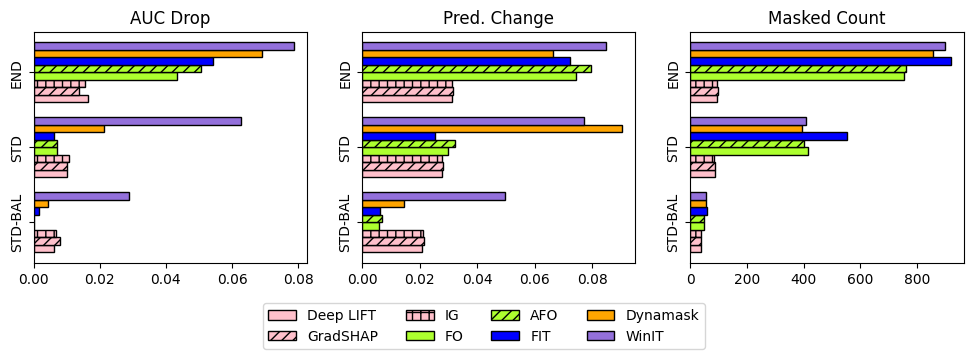

In [16]:
show_masking_barcharts("conv")

### Base model = LSTM <a class="anchor" id="bullet14"></a>$\quad$ [TOP](#bullet0) 

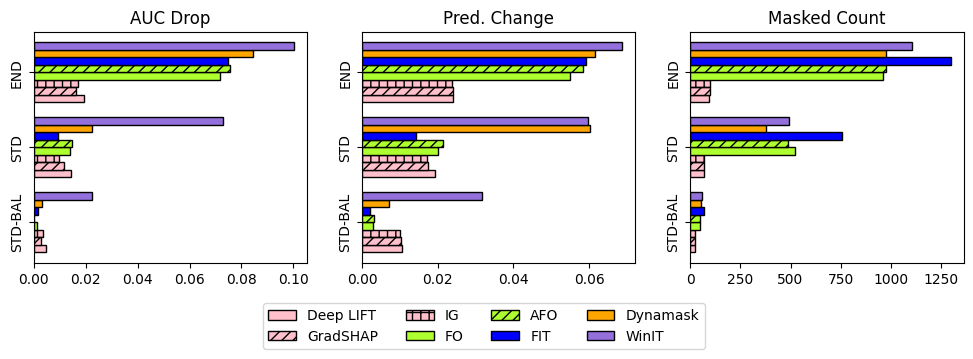

In [17]:
show_masking_barcharts("lstm")

### Base model = 3-Layer GRU <a class="anchor" id="bullet15"></a>$\quad$ [TOP](#bullet0) 

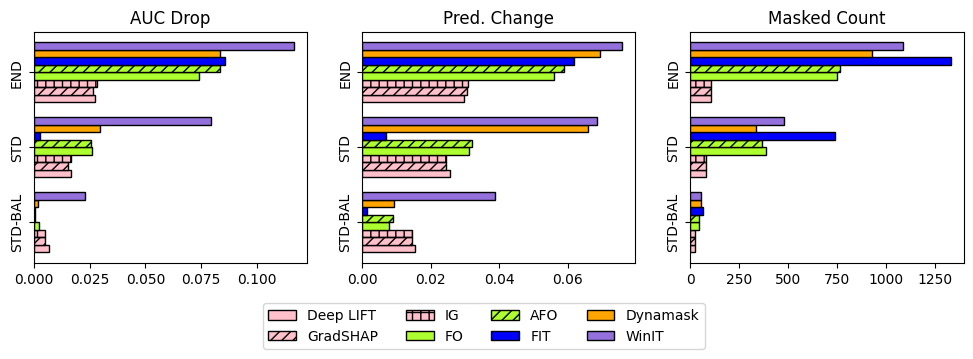

In [18]:
show_masking_barcharts("gru3layer")